In [48]:
# Importing Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
pd.set_option('display.max_columns', None)

In [52]:
# Load employee_survey.csv
df = pd.read_csv("..\\employee_survey.csv")

df = pd.get_dummies(df, columns=['JobLevel', 'EduLevel', 'Gender', 'MaritalStatus', 'Dept', 'EmpType', 'CommuteMode'])
df.head()

,EmpID,Age,Experience,WLB,WorkEnv,PhysicalActivityHours,Workload,Stress,SleepHours,CommuteDistance,NumCompanies,TeamSize,NumReports,haveOT,TrainingHoursPerYear,JobSatisfaction,JobLevel_Intern/Fresher,JobLevel_Junior,JobLevel_Lead,JobLevel_Mid,JobLevel_Senior,EduLevel_Bachelor,EduLevel_High School,EduLevel_Master,EduLevel_PhD,Gender_Female,Gender_Male,Gender_Other,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,Dept_Customer Service,Dept_Finance,Dept_HR,Dept_IT,Dept_Legal,Dept_Marketing,Dept_Operations,Dept_Sales,EmpType_Contract,EmpType_Full-Time,EmpType_Part-Time,CommuteMode_Bike,CommuteMode_Car,CommuteMode_Motorbike,CommuteMode_Public Transport,CommuteMode_Walk
0,6,32,7,1,1,2.5,2,1,7.6,20,3,12,0,True,33.5,5,False,False,False,True,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False
1,11,34,12,1,1,1.8,2,2,7.9,15,4,11,0,False,36.0,5,False,False,False,True,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False
2,33,23,1,2,4,2.1,5,4,6.5,17,0,30,0,True,10.5,5,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False
3,20,29,6,2,2,1.9,3,1,7.5,13,2,9,0,True,23.0,5,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False
4,28,23,1,3,1,3.7,2,1,4.9,20,0,7,0,False,20.5,5,False,True,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False


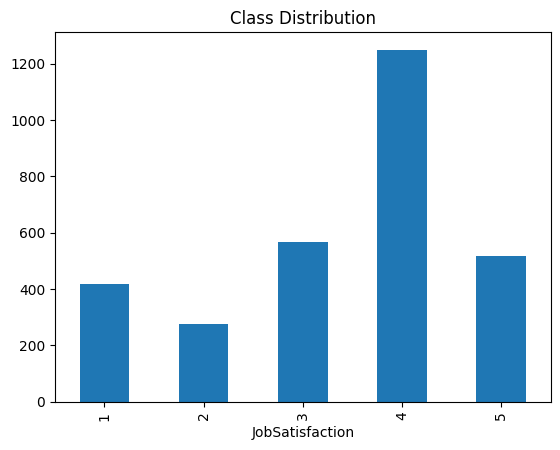

In [51]:
# Check class distribution
df['JobSatisfaction'].value_counts().sort_index().plot(kind='bar', title='Class Distribution')
plt.show()

In [ ]:
X = df.drop(columns=['JobSatisfaction'])
y = df['JobSatisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Classification report for SVM
model = SVC(kernel='rbf', C=1.0, gamma='scale')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.4f}")
print(classification_report(y_test, y_pred))